# Aplicación de las barras de desequilibrio con umbral fijo

Como se ha visto en el notebook anterior, las barras son muy sensibles los parametros iniciales, y además el umbral tiende a explotar.

Una de las soluciones propuestas en foros es usar un umbral fijo.

In [3]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imbalance_bars import ImbalanceBarGenerator
from helpers import *

# Añadir el directorio raíz del proyecto al PYTHONPATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import statsmodels.api as sm
import scipy.stats as stats

# Configuración de estilo de los gráficos
sns.set(style='whitegrid')
plt.rcParams.update({'font.size': 14, 'figure.figsize': (10, 6)})

In [4]:
# Importar datos
btc_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\api_data\BTC_all.parquet')
spy_data = pd.read_parquet(r'C:\Users\adelapuente\Desktop\math_tfm\api_data\SPY_all.parquet')

btc_data['date'] = pd.to_datetime(btc_data['date'])
spy_data['date'] = pd.to_datetime(spy_data['date'])

## Volume SPY

### Barrido de parámetros
Para saber por donde ando

In [3]:
# Inicializar una lista para almacenar los resultados
results_spy_vol = []

# Bucle para generar barras y almacenar los resultados
for i in range(5,15):
    threshold = i * 10**5 
    spy_vol_generator = ImbalanceBarGenerator(dataframe=spy_data, 
                                            ewma_window=10, 
                                            T_init=30,
                                            imbalance_init=spy_data['volume'].mean(),
                                            threshold_value=threshold)
    
    spy_vol_generator.fit(imbalance_type='volume')
    barras = spy_vol_generator.get_bars()
    

    results_spy_vol.append({
        'threshold':threshold,
        'bars_length': len(barras)
    })

results_spy_vol_df = pd.DataFrame(results_spy_vol)

In [4]:
results_spy_vol_df.to_csv('barrido_threshold_spy.csv')
results_spy_vol_df

,threshold,bars_length
0,500000,69641
1,600000,55431
2,700000,44845
3,800000,37712
4,900000,31784
5,1000000,27139
6,1100000,24248
7,1200000,21194
8,1300000,18908
9,1400000,17193


### Umbral fijo
Aplicación con un umbral fijo de 2*16^6. El resto de parámetros dan igual cuando defino un umbral fijo.

In [103]:
umbral = 6*10**5

In [104]:
spy_vol_generator = ImbalanceBarGenerator(dataframe=spy_data, 
                                            ewma_window=10, 
                                            T_init=30,
                                            imbalance_init=spy_data['volume'].mean(),
                                            threshold_value=umbral)
    
spy_vol_generator.fit(imbalance_type='volume')

spy_new_series_vol = spy_vol_generator.get_bars()

spy_new_series_vol = calculate_log_returns(spy_new_series_vol)
spy_new_series_vol.to_parquet('SPY_volume_imbalance.parquet')
len(spy_new_series_vol)

55430

In [105]:
print(f'La serie original tiene {len(spy_data)} muestras')
print(f'La serie filtrada tiene {len(spy_new_series_vol)} muestras')

# Cálculo del porcentaje de reducción
reduction_percentage = ((len(spy_data) - len(spy_new_series_vol)) / len(spy_data)) * 100

# Mostrar el resultado
print(f'La reducción ha sido de aproximadamente {reduction_percentage:.2f}%')


La serie original tiene 662353 muestras
La serie filtrada tiene 55430 muestras
La reducción ha sido de aproximadamente 91.63%


In [106]:
spy_new_series_vol.head()

,date,open,high,low,close,log_returns
1,2018-01-02 09:34:00,242.108,242.223,241.605,241.719,-0.000823
2,2018-01-02 09:38:00,241.918,242.259,241.550,241.945,0.000935
3,2018-01-02 09:40:00,242.144,242.413,241.840,242.076,0.000541
4,2018-01-02 09:49:00,242.271,242.431,241.776,241.909,-0.000690
5,2018-01-02 09:59:00,242.099,242.494,241.731,242.180,0.001120


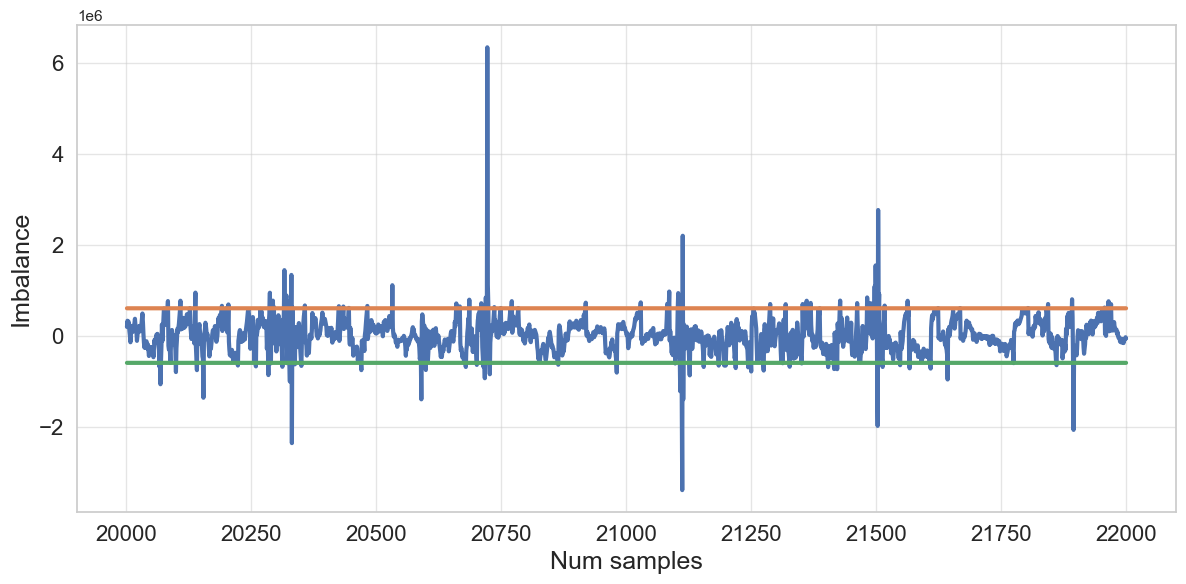

In [107]:
limit1 = 20000
limit2 = 22000
plt.figure(figsize=(12, 6))  
plt.plot(spy_vol_generator.get_series('cum_imbalance')[limit1:limit2], lw = 3)
plt.plot(spy_vol_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.plot(-spy_vol_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.ylabel('Imbalance', fontsize=18)
plt.xlabel('Num samples', fontsize=18)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.plot(-generator.get_series('expected_imbalance')[:])
plt.grid(alpha = 0.5)
#plt.title(f'SPY Volume Imbalance (T={T_init}, EWMA window = {ewma_window})', fontsize = 22)
plt.show()

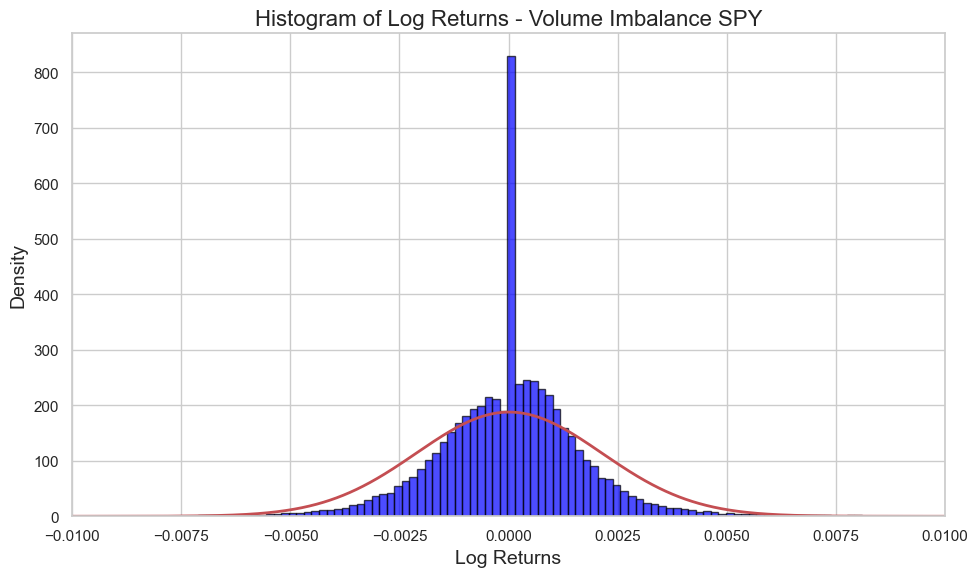

In [108]:

# Histograma de los log-returns
filename = 'SPY_hist_log_ret_vol_ldp'
fig, ax = plt.subplots()
log_returns = spy_new_series_vol['log_returns'].dropna()

# Calcular el histograma y obtener los parámetros
count, bins, ignored = ax.hist(log_returns, bins=1000, color='blue', edgecolor='black', alpha=0.7, density=True)

# Ajustar una curva normal a los datos
mu, std = stats.norm.fit(log_returns)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 10000)
p = stats.norm.pdf(x, mu, std)

# Graficar la curva normal ajustada al histograma
ax.plot(x, p, 'r', linewidth=2)

ax.set_title('Histogram of Log Returns - Volume Imbalance SPY', fontsize=16)
ax.set_xlabel('Log Returns', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([-0.01, 0.01])

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

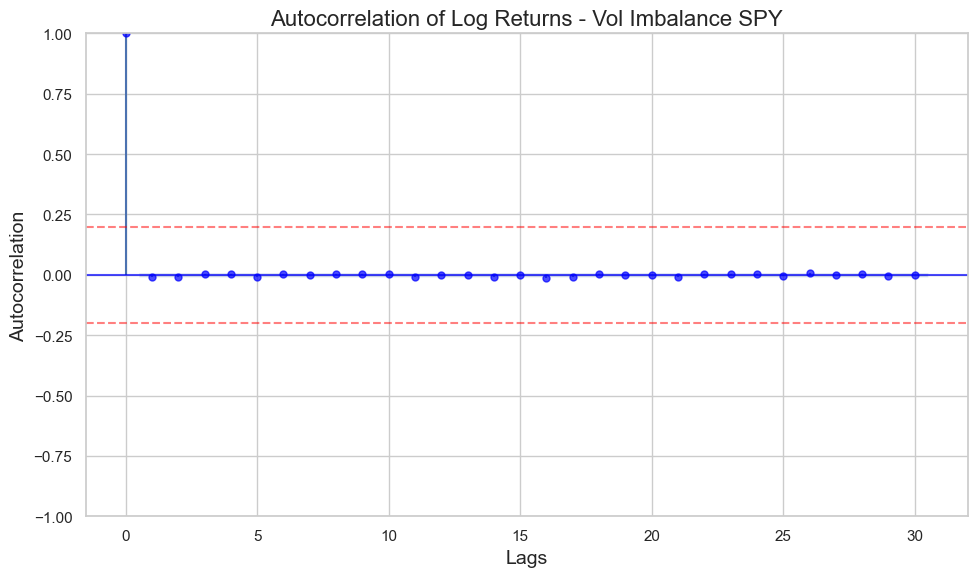

In [109]:
# 1. Autocorrelación de los log-returns
filename = 'SPY_autocorr_log_ret_vol_imb'
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(spy_new_series_vol['log_returns'].dropna(), lags=30, ax=ax)

# Configurar colores y estilos
lines = ax.get_lines()
for line in lines:
    line.set_color('blue')
    line.set_alpha(0.7)
    line.set_markerfacecolor('blue')
    line.set_markeredgecolor('blue')

ax.axhline(y=0.2, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=-0.2, linestyle='--', color='red', alpha=0.5)

ax.set_title('Autocorrelation of Log Returns - Vol Imbalance SPY', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

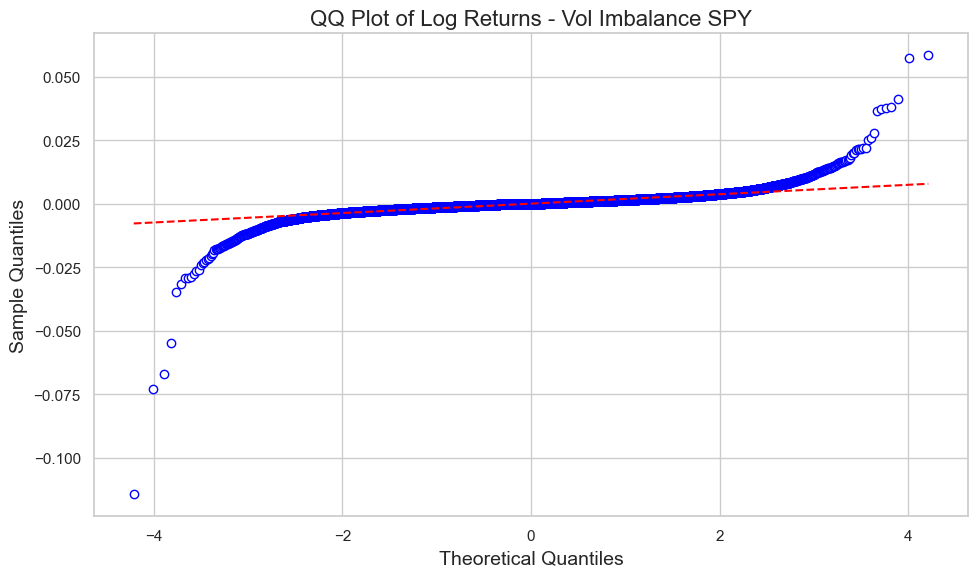

In [110]:
# 3. QQ plot de los log-returns
filename = 'SPY_qq_vol_imbalance'
fig, ax = plt.subplots()
stats.probplot(spy_new_series_vol['log_returns'].dropna(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('blue')
ax.set_title('QQ Plot of Log Returns - Vol Imbalance SPY', fontsize=16)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

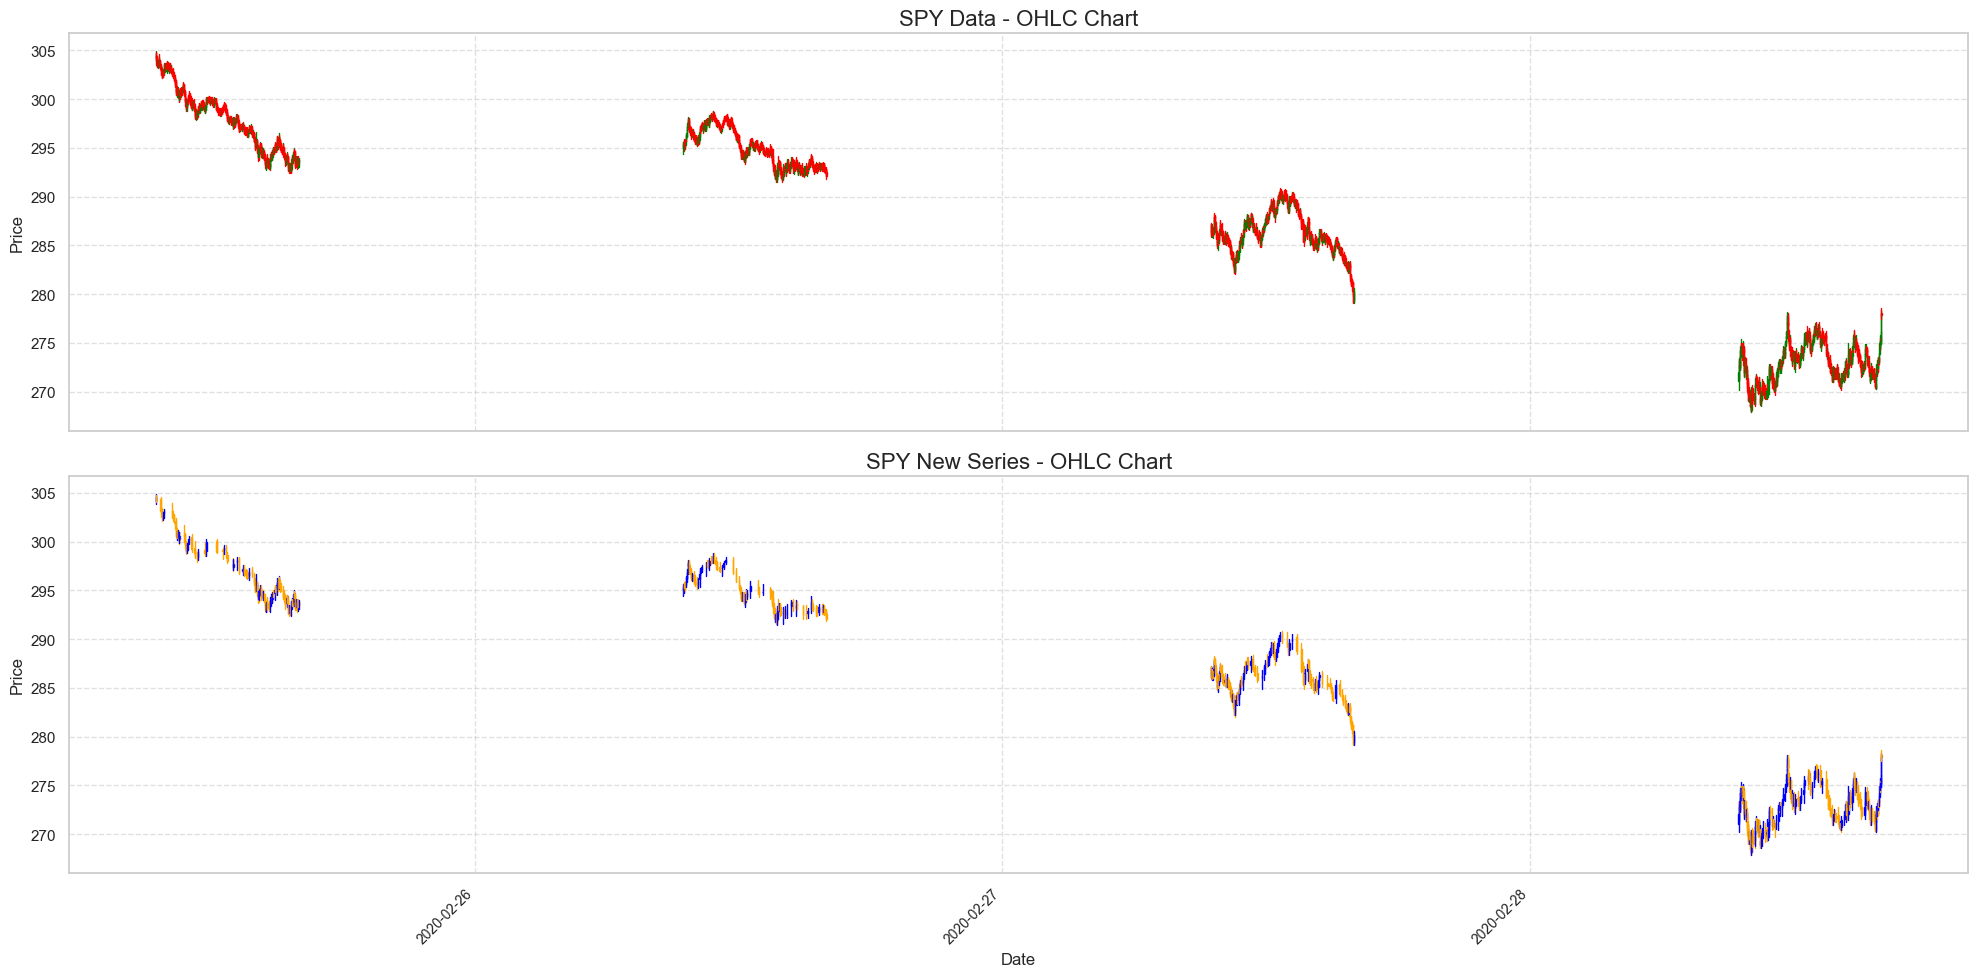

In [111]:
# Asegurarse de que la columna 'date' es de tipo datetime
spy_data['date'] = pd.to_datetime(spy_data['date'])
spy_new_series_vol['date'] = pd.to_datetime(spy_new_series_vol['date'])

# Filtrar los datos para los meses de febrero y marzo de 2020
covid_start = '2020-02-25'
covid_end = '2020-02-29'

spy_data_filtered = spy_data[(spy_data['date'] >= covid_start) & (spy_data['date'] <= covid_end)]
spy_new_series_filtered = spy_new_series_vol[(spy_new_series_vol['date'] >= covid_start) & (spy_new_series_vol['date'] <= covid_end)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

plot_ohlc(ax1, spy_data_filtered, color_up='green', color_down='red')
plot_ohlc(ax2, spy_new_series_filtered, color_up='blue', color_down='orange')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')

ax1.set_title('SPY Data - OHLC Chart', fontsize=16)
ax1.set_ylabel('Price', fontsize=12)
ax2.set_title('SPY New Series - OHLC Chart', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Price', fontsize=12)

plt.tight_layout()
plt.show()

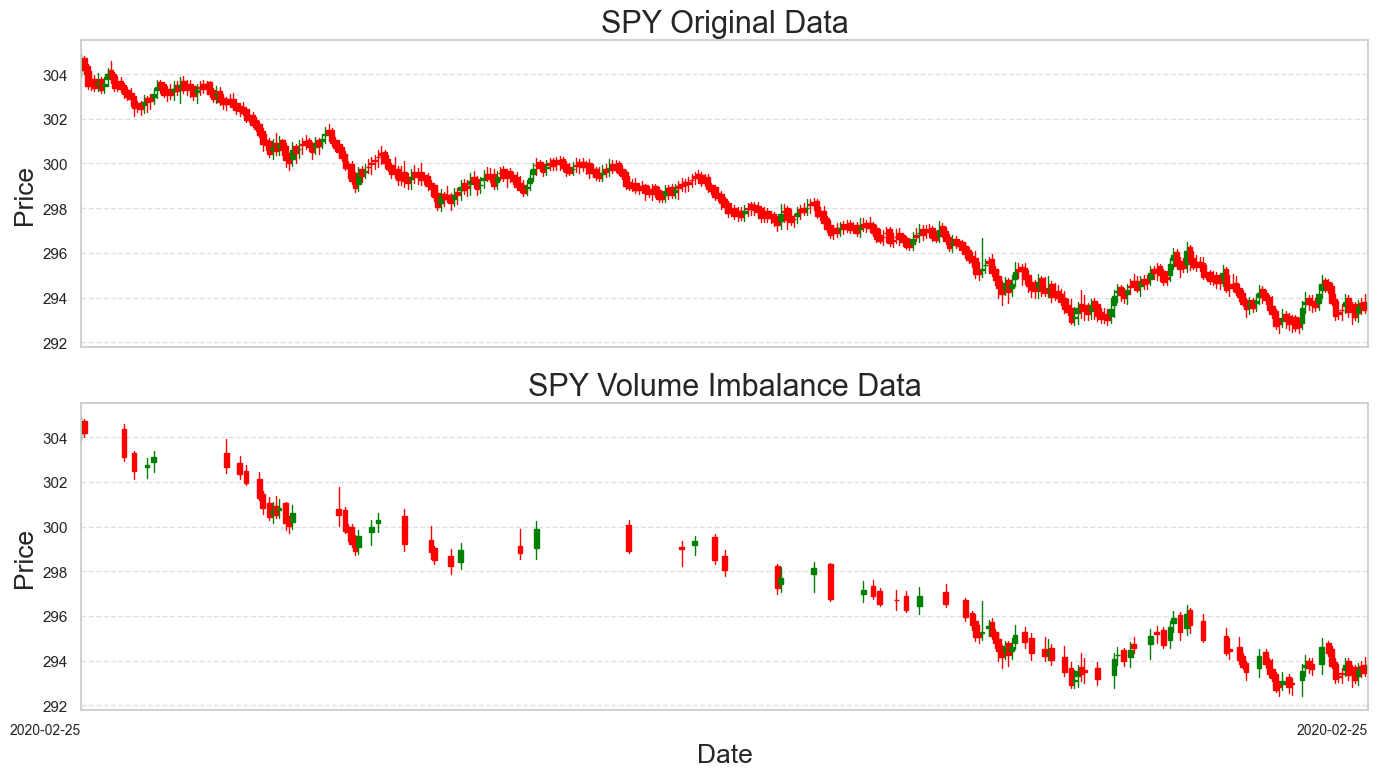

In [112]:

filename = 'spy_original_vol_imabalance_comp'

# Asegurarse de que la columna 'date' es de tipo datetime
spy_data['date'] = pd.to_datetime(spy_data['date'])
spy_new_series_vol['date'] = pd.to_datetime(spy_new_series_vol['date'])

# Filtrar los datos para los meses de febrero y marzo de 2020
covid_start = '2020-02-25'
covid_end = '2020-02-26'

spy_data_filtered = spy_data[(spy_data['date'] >= covid_start) & (spy_data['date'] <= covid_end)]
spy_new_series_filtered = spy_new_series_vol[(spy_new_series_vol['date'] >= covid_start) & (spy_new_series_vol['date'] <= covid_end)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

plot_ohlc(ax1, spy_data_filtered, color_up='green', color_down='red')
plot_ohlc(ax2, spy_new_series_filtered, color_up='green', color_down='red')

# Ajustar el rango del eje x para eliminar huecos
min_date = spy_data_filtered['date'].min()
max_date = spy_data_filtered['date'].max()

for ax in [ax1, ax2]:
    ax.set_xlim([min_date, max_date])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')

ax1.set_title('SPY Original Data', fontsize=22)
ax1.set_ylabel('Price', fontsize=19)
ax2.set_title('SPY Volume Imbalance Data', fontsize=22)
ax2.set_xlabel('Date', fontsize=19)
ax2.set_ylabel('Price', fontsize=19)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

In [113]:
# Realizar el test de Jarque-Bera
jb_stat, p_value = stats.jarque_bera(log_returns)

print(f"JB Statistic: {jb_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.")
else:
    print("No se puede rechazar la hipótesis nula: Los datos siguen una distribución normal.")

JB Statistic: 140649527.8555417
p-value: 0.0
Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.


## Dollar SPY

### Barrido de parámetros

In [18]:
# Inicializar una lista para almacenar los resultados
results_spy_dollar = []

# Bucle para generar barras y almacenar los resultados
for i in range(5,15):
    threshold = i * 10**7
    #print(i, threshold)

    spy_generator = ImbalanceBarGenerator(dataframe=spy_data, 
                                            ewma_window=10, 
                                            T_init=30,
                                            imbalance_init=spy_data['volume'].mean(),
                                            threshold_value=threshold)
    
    spy_generator.fit(imbalance_type='dollar')
    barras = spy_generator.get_bars()
    

    results_spy_dollar.append({
        'threshold':threshold,
        'bars_length': len(barras)
    })

# Convertir la lista de resultados en un DataFrame
results_spy_dollar_df = pd.DataFrame(results_spy_dollar)

In [19]:
results_spy_dollar_df.to_csv('barrido_threshold_spy_dollar.csv')
results_spy_dollar_df

,threshold,bars_length
0,500000000,16511
1,600000000,12735
2,700000000,10169
3,800000000,8390
4,900000000,7146
5,1000000000,6180
6,1100000000,5397
7,1200000000,4783
8,1300000000,4260
9,1400000000,3805


### Umbral fijo

In [114]:
umbral = 15*10**7

In [115]:
spy_dollar_generator = ImbalanceBarGenerator(dataframe=spy_data, 
                                            ewma_window=10, 
                                            T_init=30,
                                            imbalance_init=spy_data['volume'].mean(),
                                            threshold_value=umbral)
    
spy_dollar_generator.fit(imbalance_type='dollar')

spy_new_series_dollar = spy_dollar_generator.get_bars()

spy_new_series_dollar = calculate_log_returns(spy_new_series_dollar)
spy_new_series_dollar.to_parquet('SPY_dollar_imbalance.parquet')
len(spy_new_series_dollar)

85228

In [116]:
print(f'La serie original tiene {len(spy_data)} muestras')
print(f'La serie filtrada tiene {len(spy_new_series_dollar)} muestras')

# Cálculo del porcentaje de reducción
reduction_percentage = ((len(spy_data) - len(spy_new_series_dollar)) / len(spy_data)) * 100

# Mostrar el resultado
print(f'La reducción ha sido de aproximadamente {reduction_percentage:.2f}%')

La serie original tiene 662353 muestras
La serie filtrada tiene 85228 muestras
La reducción ha sido de aproximadamente 87.13%


In [117]:
spy_new_series_dollar.head()

,date,open,high,low,close,log_returns
1,2018-01-02 09:36:00,242.108,242.223,241.550,241.710,-0.000860
2,2018-01-02 09:38:00,241.909,242.259,241.605,241.945,0.000972
3,2018-01-02 09:40:00,242.144,242.413,241.840,242.076,0.000541
4,2018-01-02 09:49:00,242.271,242.431,241.776,241.909,-0.000690
5,2018-01-02 09:59:00,242.099,242.494,241.731,242.180,0.001120


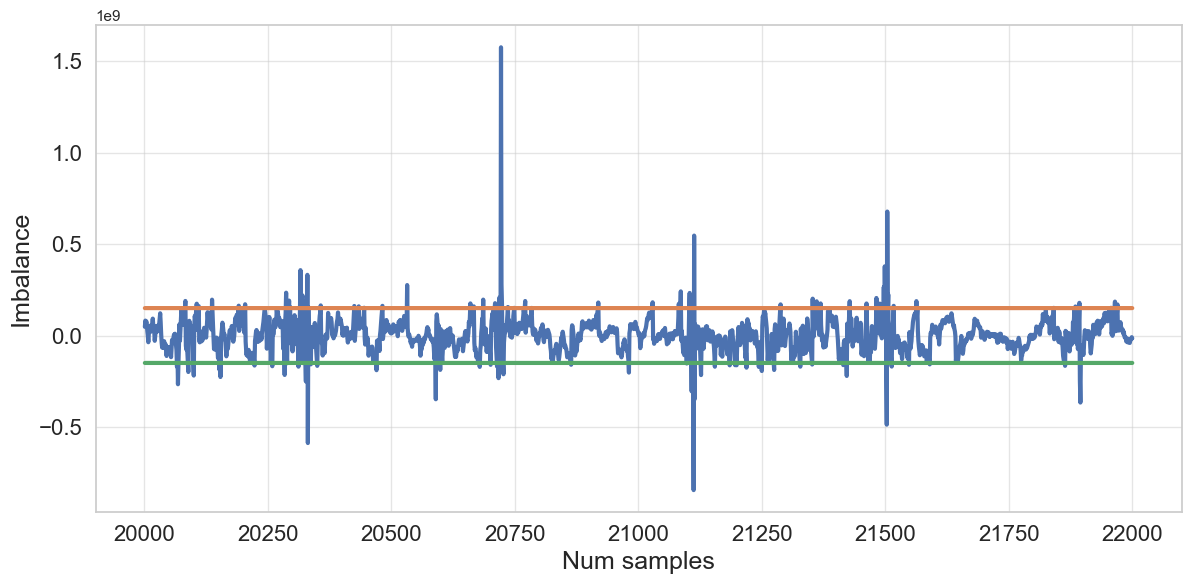

In [118]:
limit1 = 20000
limit2 = 22000
plt.figure(figsize=(12, 6))  
plt.plot(spy_dollar_generator.get_series('cum_imbalance')[limit1:limit2], lw = 3)
plt.plot(spy_dollar_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.plot(-spy_dollar_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.ylabel('Imbalance', fontsize=18)
plt.xlabel('Num samples', fontsize=18)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.plot(-generator.get_series('expected_imbalance')[:])
plt.grid(alpha = 0.5)
#plt.title(f'SPY Volume Imbalance (T={T_init}, EWMA window = {ewma_window})', fontsize = 22)
plt.show()

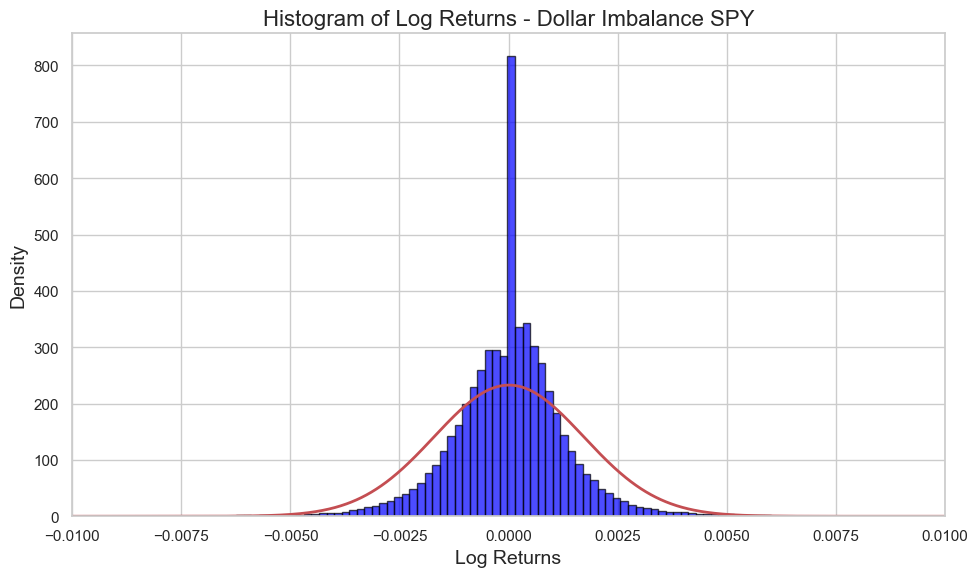

In [119]:
# Histograma de los log-returns
filename = 'SPY_hist_log_ret_dollar_ldp'
fig, ax = plt.subplots()
log_returns = spy_new_series_dollar['log_returns'].dropna()

# Calcular el histograma y obtener los parámetros
count, bins, ignored = ax.hist(log_returns, bins=1000, color='blue', edgecolor='black', alpha=0.7, density=True)

# Ajustar una curva normal a los datos
mu, std = stats.norm.fit(log_returns)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 10000)
p = stats.norm.pdf(x, mu, std)

# Graficar la curva normal ajustada al histograma
ax.plot(x, p, 'r', linewidth=2)

ax.set_title('Histogram of Log Returns - Dollar Imbalance SPY', fontsize=16)
ax.set_xlabel('Log Returns', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([-0.01, 0.01])

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

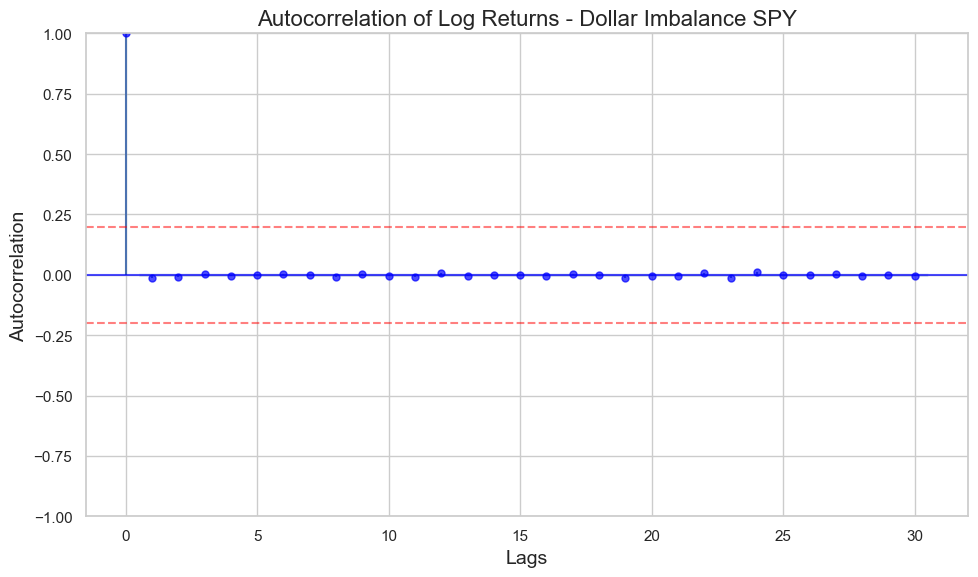

In [120]:
# 1. Autocorrelación de los log-returns
filename = 'SPY_autocorr_log_ret_dollar_imb'
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(spy_new_series_dollar['log_returns'].dropna(), lags=30, ax=ax)

# Configurar colores y estilos
lines = ax.get_lines()
for line in lines:
    line.set_color('blue')
    line.set_alpha(0.7)
    line.set_markerfacecolor('blue')
    line.set_markeredgecolor('blue')

ax.axhline(y=0.2, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=-0.2, linestyle='--', color='red', alpha=0.5)

ax.set_title('Autocorrelation of Log Returns - Dollar Imbalance SPY', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

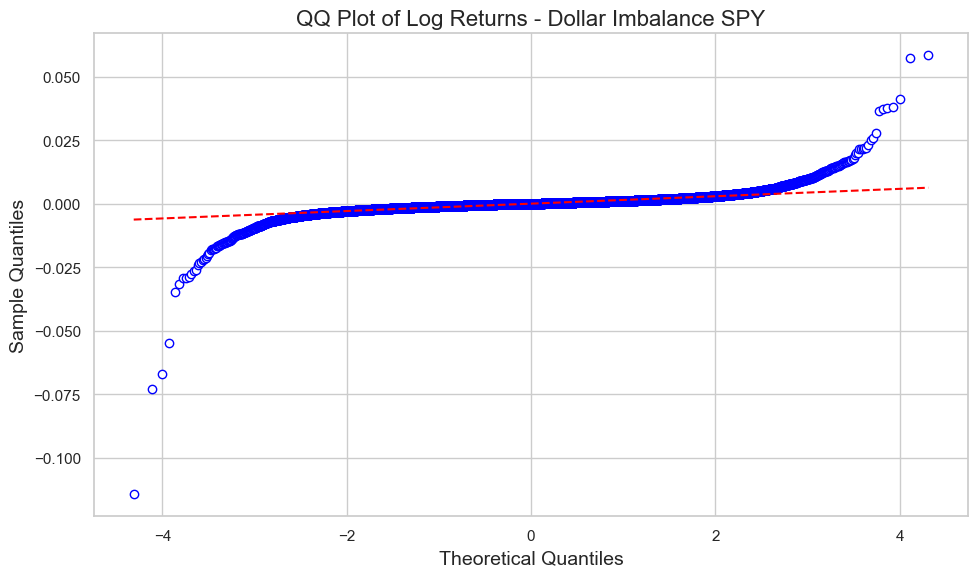

In [121]:
# 3. QQ plot de los log-returns
filename = 'SPY_qq_dollar_imbalance'
fig, ax = plt.subplots()
stats.probplot(spy_new_series_dollar['log_returns'].dropna(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('blue')
ax.set_title('QQ Plot of Log Returns - Dollar Imbalance SPY', fontsize=16)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

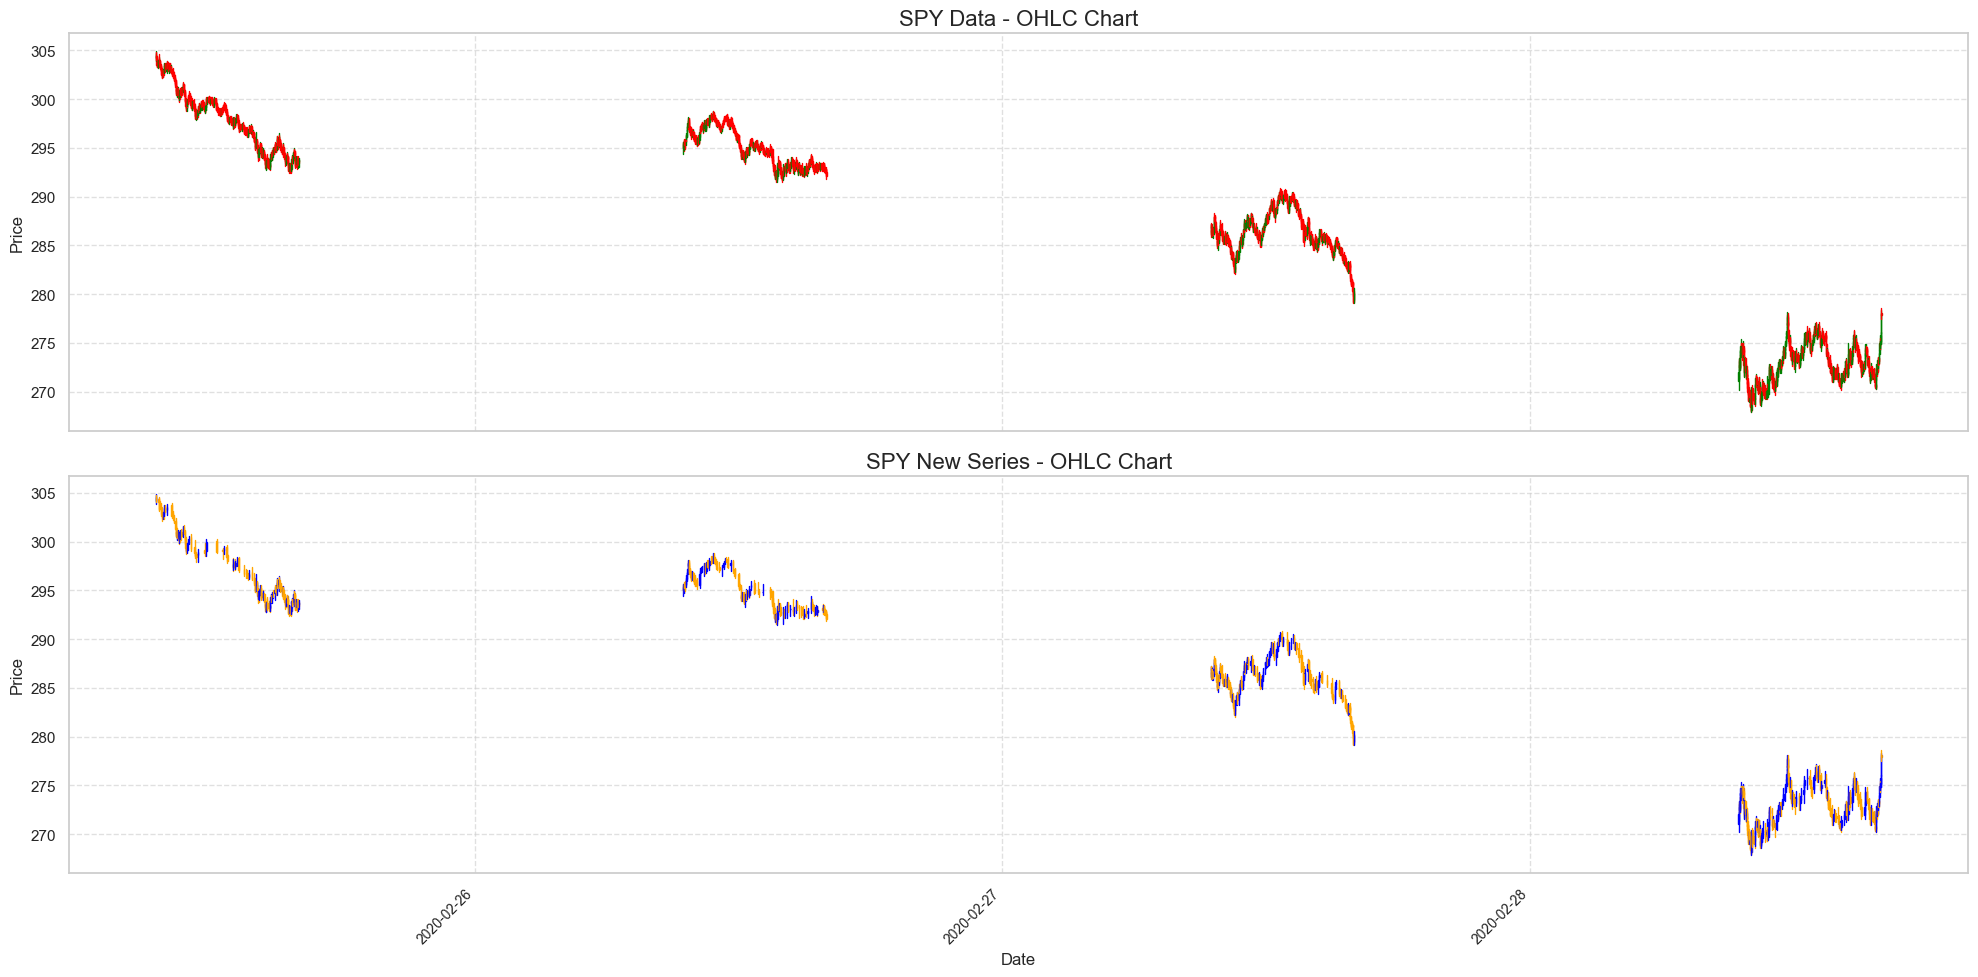

In [122]:
# Asegurarse de que la columna 'date' es de tipo datetime
spy_data['date'] = pd.to_datetime(spy_data['date'])
spy_new_series_dollar['date'] = pd.to_datetime(spy_new_series_dollar['date'])

# Filtrar los datos para los meses de febrero y marzo de 2020
covid_start = '2020-02-25'
covid_end = '2020-02-29'

spy_data_filtered = spy_data[(spy_data['date'] >= covid_start) & (spy_data['date'] <= covid_end)]
spy_new_series_filtered = spy_new_series_dollar[(spy_new_series_dollar['date'] >= covid_start) & (spy_new_series_dollar['date'] <= covid_end)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

plot_ohlc(ax1, spy_data_filtered, color_up='green', color_down='red')
plot_ohlc(ax2, spy_new_series_filtered, color_up='blue', color_down='orange')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')

ax1.set_title('SPY Data - OHLC Chart', fontsize=16)
ax1.set_ylabel('Price', fontsize=12)
ax2.set_title('SPY New Series - OHLC Chart', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Price', fontsize=12)

plt.tight_layout()
plt.show()

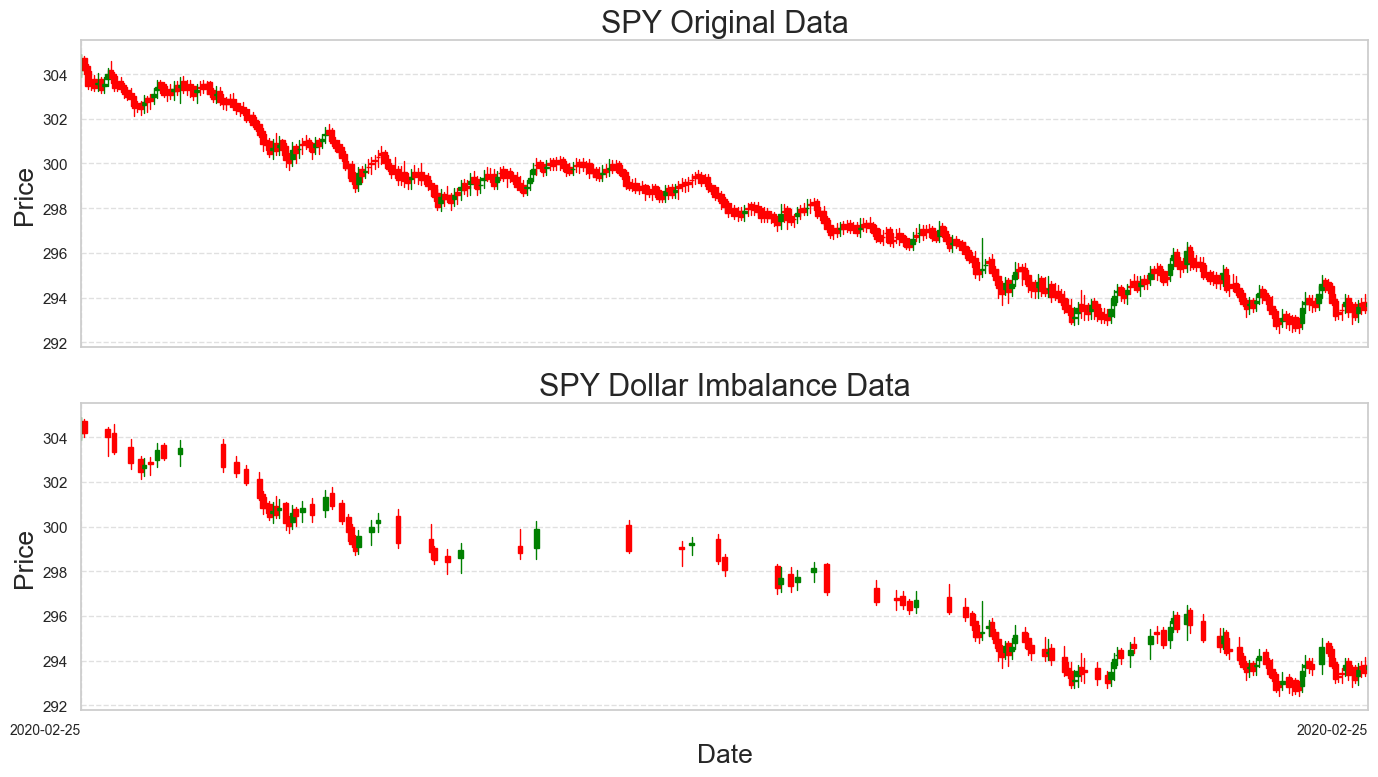

In [123]:
filename = 'spy_original_dollar_imabalance_comp'

# Asegurarse de que la columna 'date' es de tipo datetime
spy_data['date'] = pd.to_datetime(spy_data['date'])
spy_new_series_vol['date'] = pd.to_datetime(spy_new_series_vol['date'])

# Filtrar los datos para los meses de febrero y marzo de 2020
covid_start = '2020-02-25'
covid_end = '2020-02-26'

spy_data_filtered = spy_data[(spy_data['date'] >= covid_start) & (spy_data['date'] <= covid_end)]
spy_new_series_filtered = spy_new_series_dollar[(spy_new_series_dollar['date'] >= covid_start) & (spy_new_series_dollar['date'] <= covid_end)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

plot_ohlc(ax1, spy_data_filtered, color_up='green', color_down='red')
plot_ohlc(ax2, spy_new_series_filtered, color_up='green', color_down='red')

# Ajustar el rango del eje x para eliminar huecos
min_date = spy_data_filtered['date'].min()
max_date = spy_data_filtered['date'].max()

for ax in [ax1, ax2]:
    ax.set_xlim([min_date, max_date])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')

ax1.set_title('SPY Original Data', fontsize=22)
ax1.set_ylabel('Price', fontsize=19)
ax2.set_title('SPY Dollar Imbalance Data', fontsize=22)
ax2.set_xlabel('Date', fontsize=19)
ax2.set_ylabel('Price', fontsize=19)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

In [124]:
# Realizar el test de Jarque-Bera
jb_stat, p_value = stats.jarque_bera(log_returns)

print(f"JB Statistic: {jb_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.")
else:
    print("No se puede rechazar la hipótesis nula: Los datos siguen una distribución normal.")

JB Statistic: 515027476.10923463
p-value: 0.0
Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.


## Volume BTC

### Barrido de parámetros

### Umbral fijo

In [5]:
umbral = 5*10**6

In [6]:
btc_vol_generator = ImbalanceBarGenerator(dataframe=btc_data, 
                                            ewma_window=10, 
                                            T_init=30,
                                            imbalance_init=spy_data['volume'].mean(),
                                            threshold_value=umbral)
    
btc_vol_generator.fit(imbalance_type='volume')

btc_new_series_vol = btc_vol_generator.get_bars()

btc_new_series_vol = calculate_log_returns(btc_new_series_vol)
btc_new_series_vol.to_parquet('BTC_volume_imbalance.parquet')
len(btc_new_series_vol)

110772

In [75]:
print(f'La serie original tiene {len(btc_data)} muestras')
print(f'La serie filtrada tiene {len(btc_new_series_vol)} muestras')

# Cálculo del porcentaje de reducción
reduction_percentage = ((len(btc_data) - len(btc_new_series_vol)) / len(btc_data)) * 100

# Mostrar el resultado
print(f'La reducción ha sido de aproximadamente {reduction_percentage:.2f}%')

La serie original tiene 3417119 muestras
La serie filtrada tiene 110772 muestras
La reducción ha sido de aproximadamente 96.76%


In [76]:
btc_new_series_vol.head()

,date,open,high,low,close,log_returns
1,2018-01-01 03:33:00,13840.01,14200.0,13484.00,13499.00,-0.023415
2,2018-01-01 06:05:00,13500.00,13954.6,13307.00,13313.00,-0.013875
3,2018-01-01 06:10:00,13319.29,13719.8,13183.00,13215.02,-0.007387
4,2018-01-01 06:18:00,13215.02,13593.6,13120.00,13148.05,-0.005081
5,2018-01-01 07:39:00,13550.00,13572.6,13067.62,13255.49,0.008138


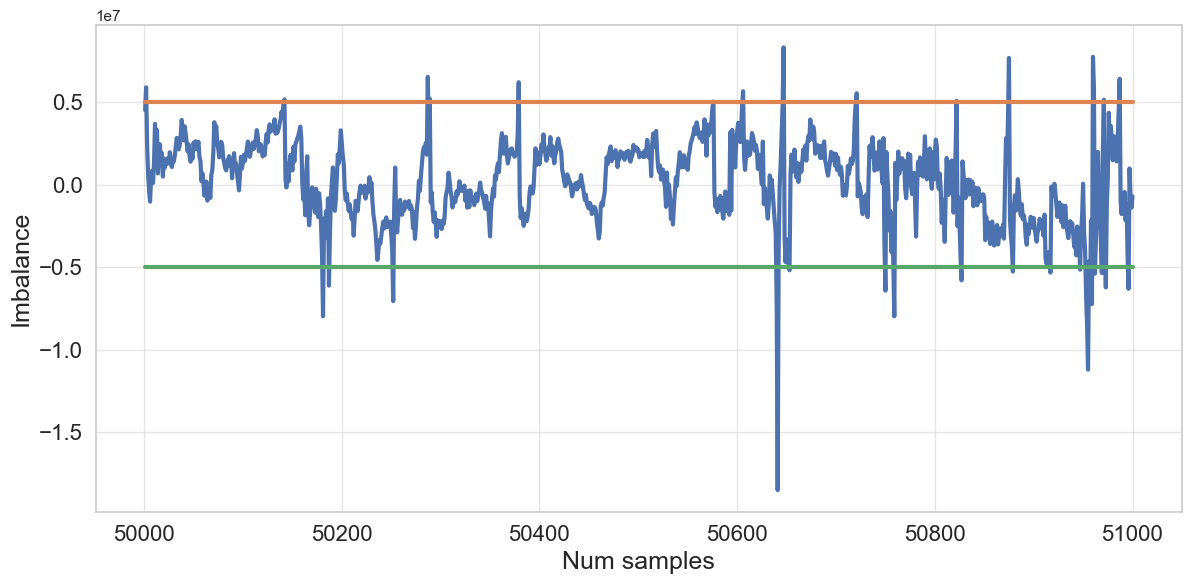

In [78]:
limit1 = 50000
limit2 = 51000
plt.figure(figsize=(12, 6))  
plt.plot(btc_vol_generator.get_series('cum_imbalance')[limit1:limit2], lw = 3)
plt.plot(btc_vol_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.plot(-btc_vol_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.ylabel('Imbalance', fontsize=18)
plt.xlabel('Num samples', fontsize=18)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.plot(-generator.get_series('expected_imbalance')[:])
plt.grid(alpha = 0.5)
#plt.title(f'SPY Volume Imbalance (T={T_init}, EWMA window = {ewma_window})', fontsize = 22)
plt.show()

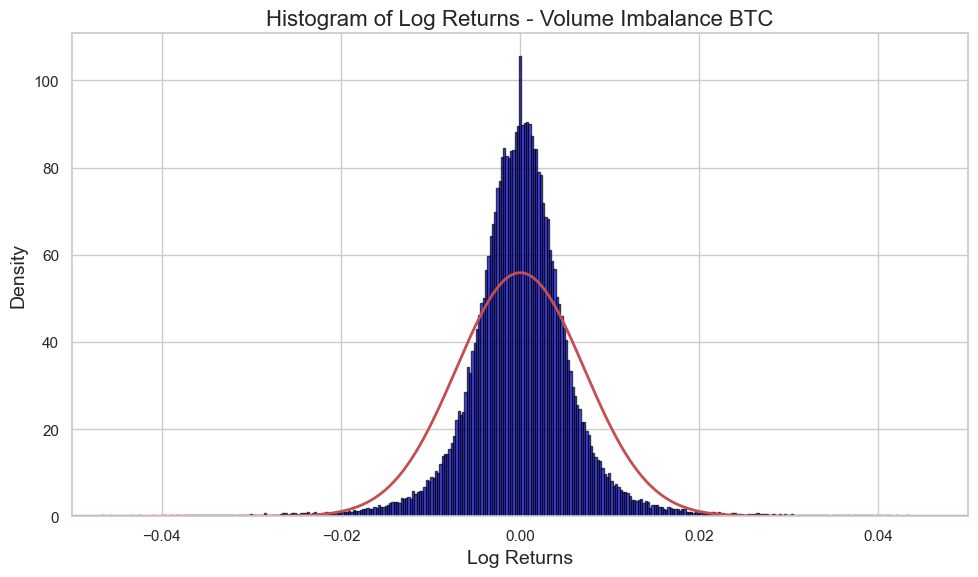

In [81]:
# Histograma de los log-returns
filename = 'BTC_hist_log_ret_volume_ldp'
fig, ax = plt.subplots()
log_returns = btc_new_series_vol['log_returns'].dropna()

# Calcular el histograma y obtener los parámetros
count, bins, ignored = ax.hist(log_returns, bins=1000, color='blue', edgecolor='black', alpha=0.7, density=True)

# Ajustar una curva normal a los datos
mu, std = stats.norm.fit(log_returns)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 10000)
p = stats.norm.pdf(x, mu, std)

# Graficar la curva normal ajustada al histograma
ax.plot(x, p, 'r', linewidth=2)

ax.set_title('Histogram of Log Returns - Volume Imbalance BTC', fontsize=16)
ax.set_xlabel('Log Returns', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([-0.05, 0.05])

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

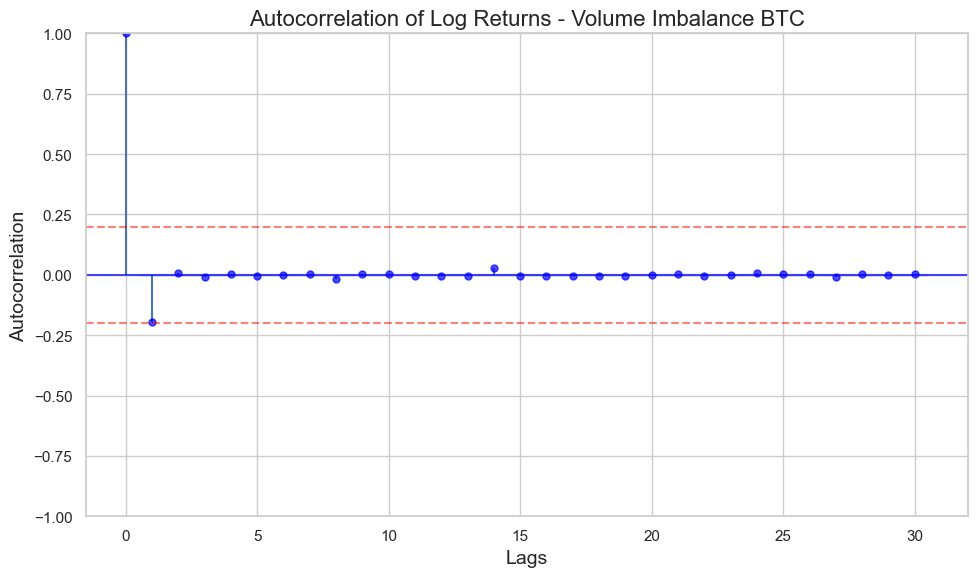

In [82]:
# 1. Autocorrelación de los log-returns
filename = 'BTC_autocorr_log_ret_volume_imb'
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(btc_new_series_vol['log_returns'].dropna(), lags=30, ax=ax)

# Configurar colores y estilos
lines = ax.get_lines()
for line in lines:
    line.set_color('blue')
    line.set_alpha(0.7)
    line.set_markerfacecolor('blue')
    line.set_markeredgecolor('blue')

ax.axhline(y=0.2, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=-0.2, linestyle='--', color='red', alpha=0.5)

ax.set_title('Autocorrelation of Log Returns - Volume Imbalance BTC', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

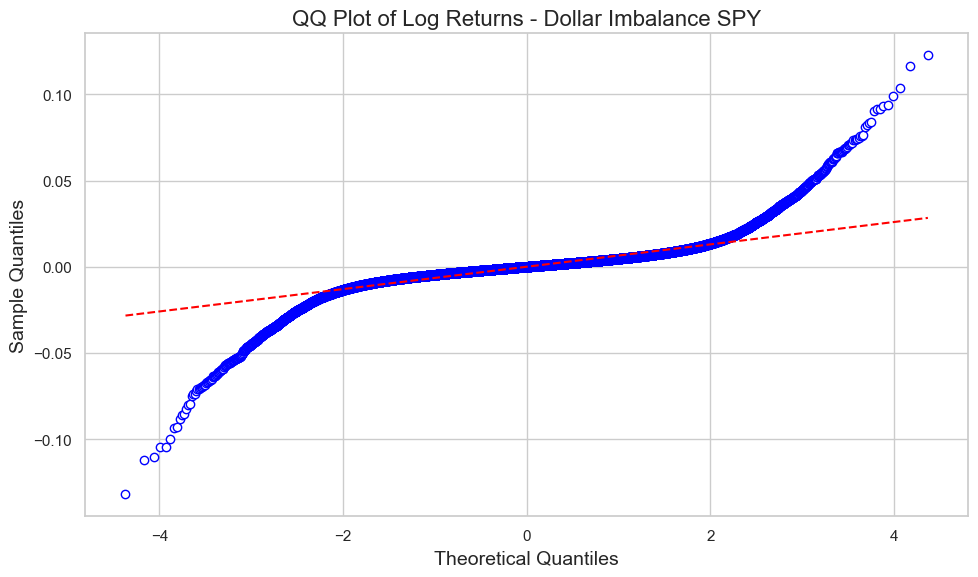

In [83]:
# 3. QQ plot de los log-returns
filename = 'BTC_qq_volume_imbalance'
fig, ax = plt.subplots()
stats.probplot(btc_new_series_vol['log_returns'].dropna(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('blue')
ax.set_title('QQ Plot of Log Returns - Dollar Imbalance SPY', fontsize=16)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

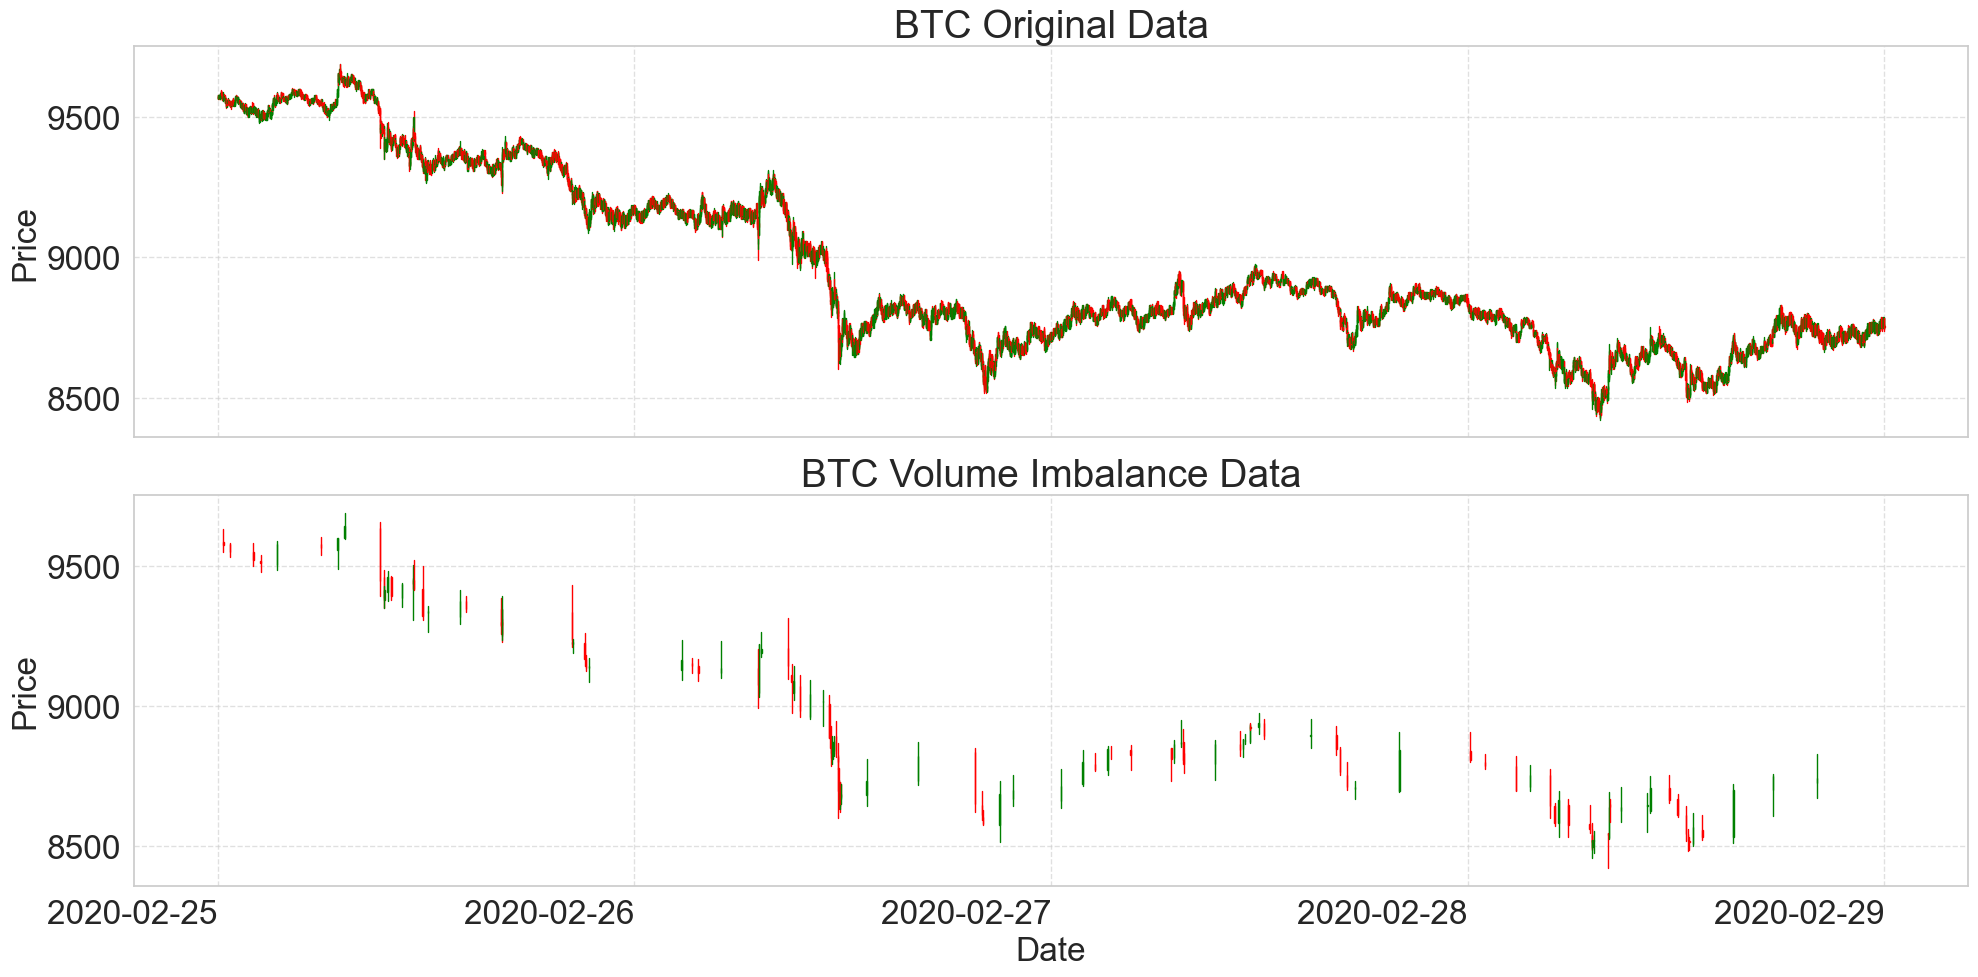

In [102]:
filename = 'btc_original_volume_imabalance_comp'
# Asegurarse de que la columna 'date' es de tipo datetime
btc_data['date'] = pd.to_datetime(btc_data['date'])
btc_new_series_vol['date'] = pd.to_datetime(btc_new_series_vol['date'])

# Filtrar los datos para los meses de febrero y marzo de 2020
covid_start = '2020-02-25'
covid_end = '2020-02-29'

btc_data_filtered = btc_data[(btc_data['date'] >= covid_start) & (btc_data['date'] <= covid_end)]
btc_new_series_filtered = btc_new_series_vol[(btc_new_series_vol['date'] >= covid_start) & (btc_new_series_vol['date'] <= covid_end)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

plot_ohlc(ax1, btc_data_filtered, color_up='green', color_down='red')
plot_ohlc(ax2, btc_new_series_filtered, color_up='green', color_down='red')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right", fontsize=24)
    ax.yaxis.set_tick_params(labelsize=24)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')

ax1.set_title('BTC Original Data', fontsize=28)
ax1.set_ylabel('Price', fontsize=24)
ax2.set_title('BTC Volume Imbalance Data', fontsize=28)
ax2.set_xlabel('Date', fontsize=24)
ax2.set_ylabel('Price', fontsize=24)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

In [89]:
# Realizar el test de Jarque-Bera
jb_stat, p_value = stats.jarque_bera(log_returns)

print(f"JB Statistic: {jb_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.")
else:
    print("No se puede rechazar la hipótesis nula: Los datos siguen una distribución normal.")

JB Statistic: 2469700.930350036
p-value: 0.0
Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.


## Dollar BTC

### Barrido de parámetros


### Umbral fijo

In [90]:
umbral = 15*10**9

In [91]:
btc_dollar_generator = ImbalanceBarGenerator(dataframe=btc_data, 
                                            ewma_window=10, 
                                            T_init=30,
                                            imbalance_init=btc_data['volume'].mean(),
                                            threshold_value=umbral)
    
btc_dollar_generator.fit(imbalance_type='dollar')

btc_new_series_dollar = btc_dollar_generator.get_bars()

btc_new_series_dollar = calculate_log_returns(btc_new_series_dollar)
btc_new_series_dollar.to_parquet('BTC_dollar_imbalance.parquet')
len(btc_new_series_dollar)

1003756

In [92]:
print(f'La serie original tiene {len(btc_data)} muestras')
print(f'La serie filtrada tiene {len(btc_new_series_dollar)} muestras')

# Cálculo del porcentaje de reducción
reduction_percentage = ((len(btc_data) - len(btc_new_series_dollar)) / len(btc_data)) * 100

# Mostrar el resultado
print(f'La reducción ha sido de aproximadamente {reduction_percentage:.2f}%')

La serie original tiene 3417119 muestras
La serie filtrada tiene 1003756 muestras
La reducción ha sido de aproximadamente 70.63%


In [ ]:
btc_new_series_dollar.head()

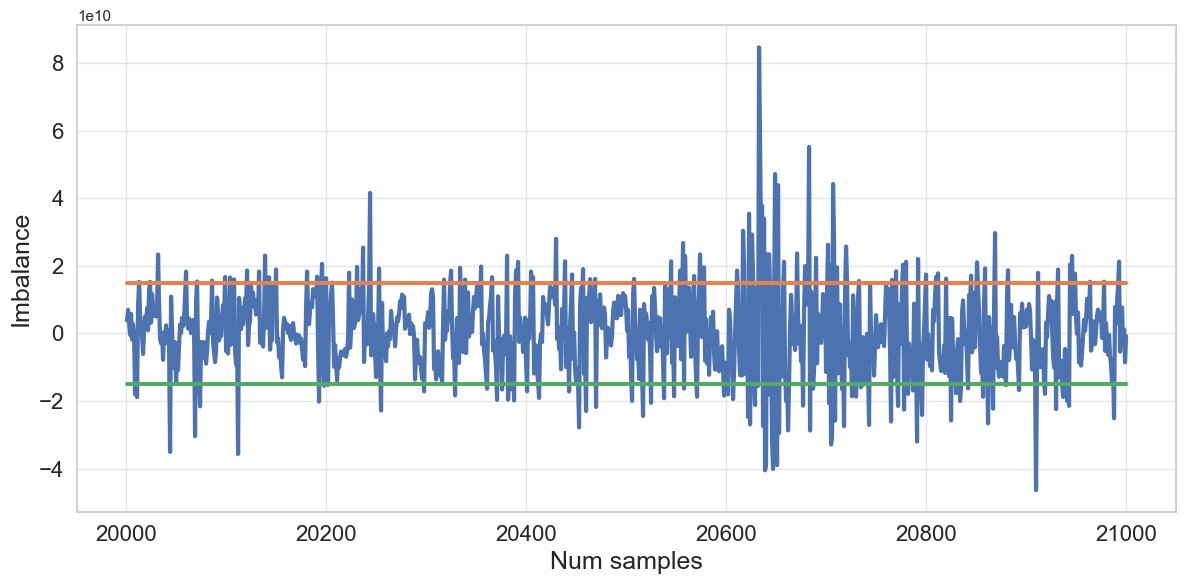

In [94]:
limit1 = 20000
limit2 = 21000
plt.figure(figsize=(12, 6))  
plt.plot(btc_dollar_generator.get_series('cum_imbalance')[limit1:limit2], lw = 3)
plt.plot(btc_dollar_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.plot(-btc_dollar_generator.get_series('expected_imbalance')[limit1:limit2], lw = 3)
plt.ylabel('Imbalance', fontsize=18)
plt.xlabel('Num samples', fontsize=18)
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=16)

#plt.plot(-generator.get_series('expected_imbalance')[:])
plt.grid(alpha = 0.5)
#plt.title(f'SPY Volume Imbalance (T={T_init}, EWMA window = {ewma_window})', fontsize = 22)
plt.show()

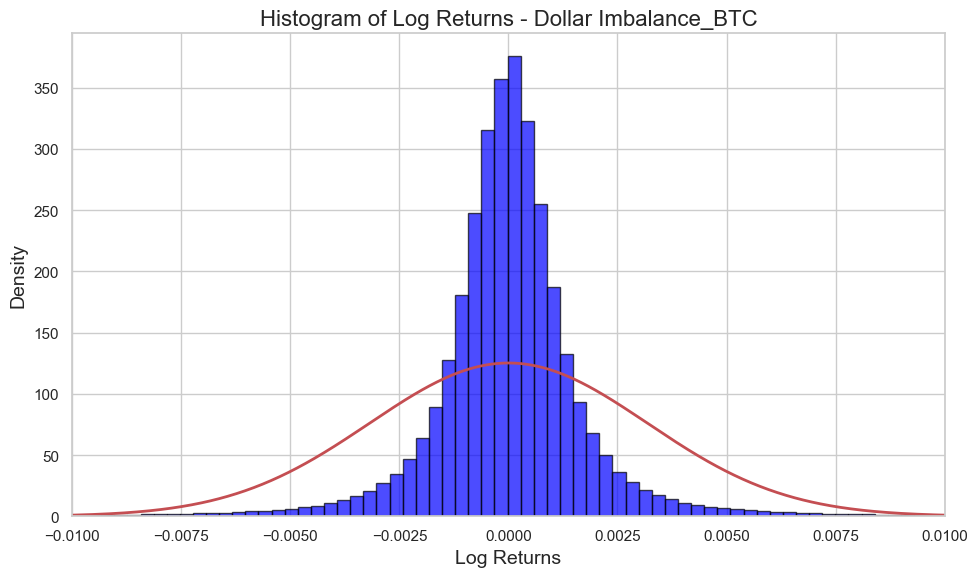

In [97]:
# Histograma de los log-returns
filename = 'BTC_hist_log_ret_dollar_ldp'
fig, ax = plt.subplots()
log_returns = btc_new_series_dollar['log_returns'].dropna()

# Calcular el histograma y obtener los parámetros
count, bins, ignored = ax.hist(log_returns, bins=1000, color='blue', edgecolor='black', alpha=0.7, density=True)

# Ajustar una curva normal a los datos
mu, std = stats.norm.fit(log_returns)
xmin, xmax = ax.get_xlim()
x = np.linspace(xmin, xmax, 10000)
p = stats.norm.pdf(x, mu, std)

# Graficar la curva normal ajustada al histograma
ax.plot(x, p, 'r', linewidth=2)

ax.set_title('Histogram of Log Returns - Dollar Imbalance_BTC', fontsize=16)
ax.set_xlabel('Log Returns', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
ax.set_xlim([-0.01, 0.01])

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

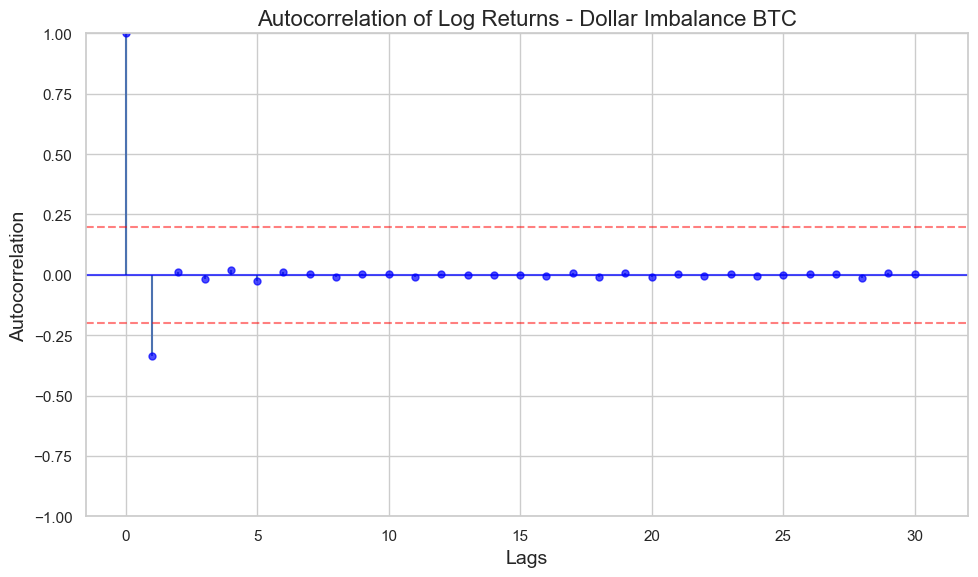

In [98]:
# 1. Autocorrelación de los log-returns
filename = 'BTC_autocorr_log_ret_dollar_imb'
fig, ax = plt.subplots()
sm.graphics.tsa.plot_acf(btc_new_series_dollar['log_returns'].dropna(), lags=30, ax=ax)

# Configurar colores y estilos
lines = ax.get_lines()
for line in lines:
    line.set_color('blue')
    line.set_alpha(0.7)
    line.set_markerfacecolor('blue')
    line.set_markeredgecolor('blue')

ax.axhline(y=0.2, linestyle='--', color='red', alpha=0.5)
ax.axhline(y=-0.2, linestyle='--', color='red', alpha=0.5)

ax.set_title('Autocorrelation of Log Returns - Dollar Imbalance BTC', fontsize=16)
ax.set_xlabel('Lags', fontsize=14)
ax.set_ylabel('Autocorrelation', fontsize=14)

plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

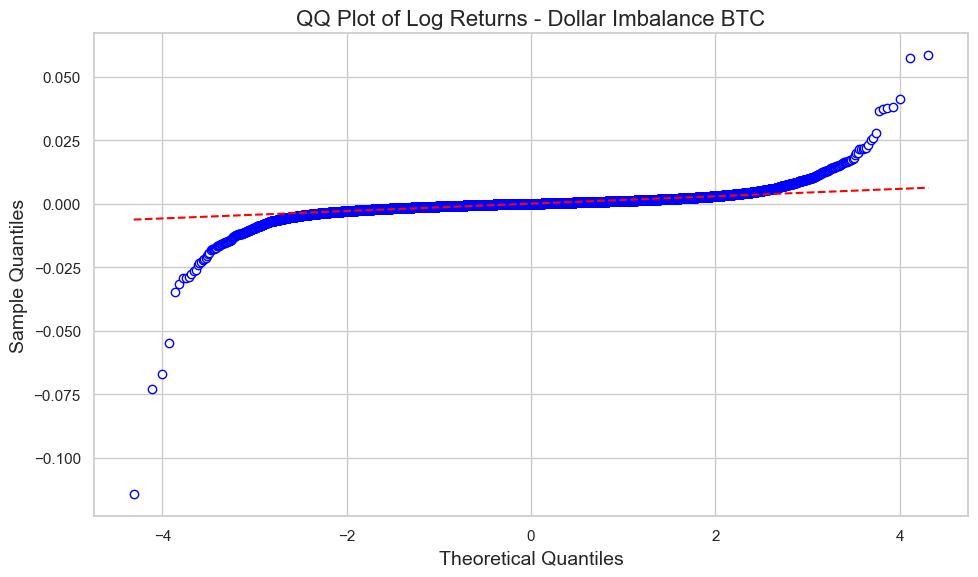

In [99]:
# 3. QQ plot de los log-returns
filename = 'BTC_qq_dollar_imbalance'
fig, ax = plt.subplots()
stats.probplot(spy_new_series_dollar['log_returns'].dropna(), dist="norm", plot=ax)
ax.get_lines()[1].set_color('red')
ax.get_lines()[1].set_linestyle('--')
ax.get_lines()[0].set_markerfacecolor('white')
ax.get_lines()[0].set_markeredgecolor('blue')
ax.set_title('QQ Plot of Log Returns - Dollar Imbalance BTC', fontsize=16)
ax.set_xlabel('Theoretical Quantiles', fontsize=14)
ax.set_ylabel('Sample Quantiles', fontsize=14)
plt.tight_layout()
plt.savefig('../tfm/figures/' + filename + '.png')
plt.show()

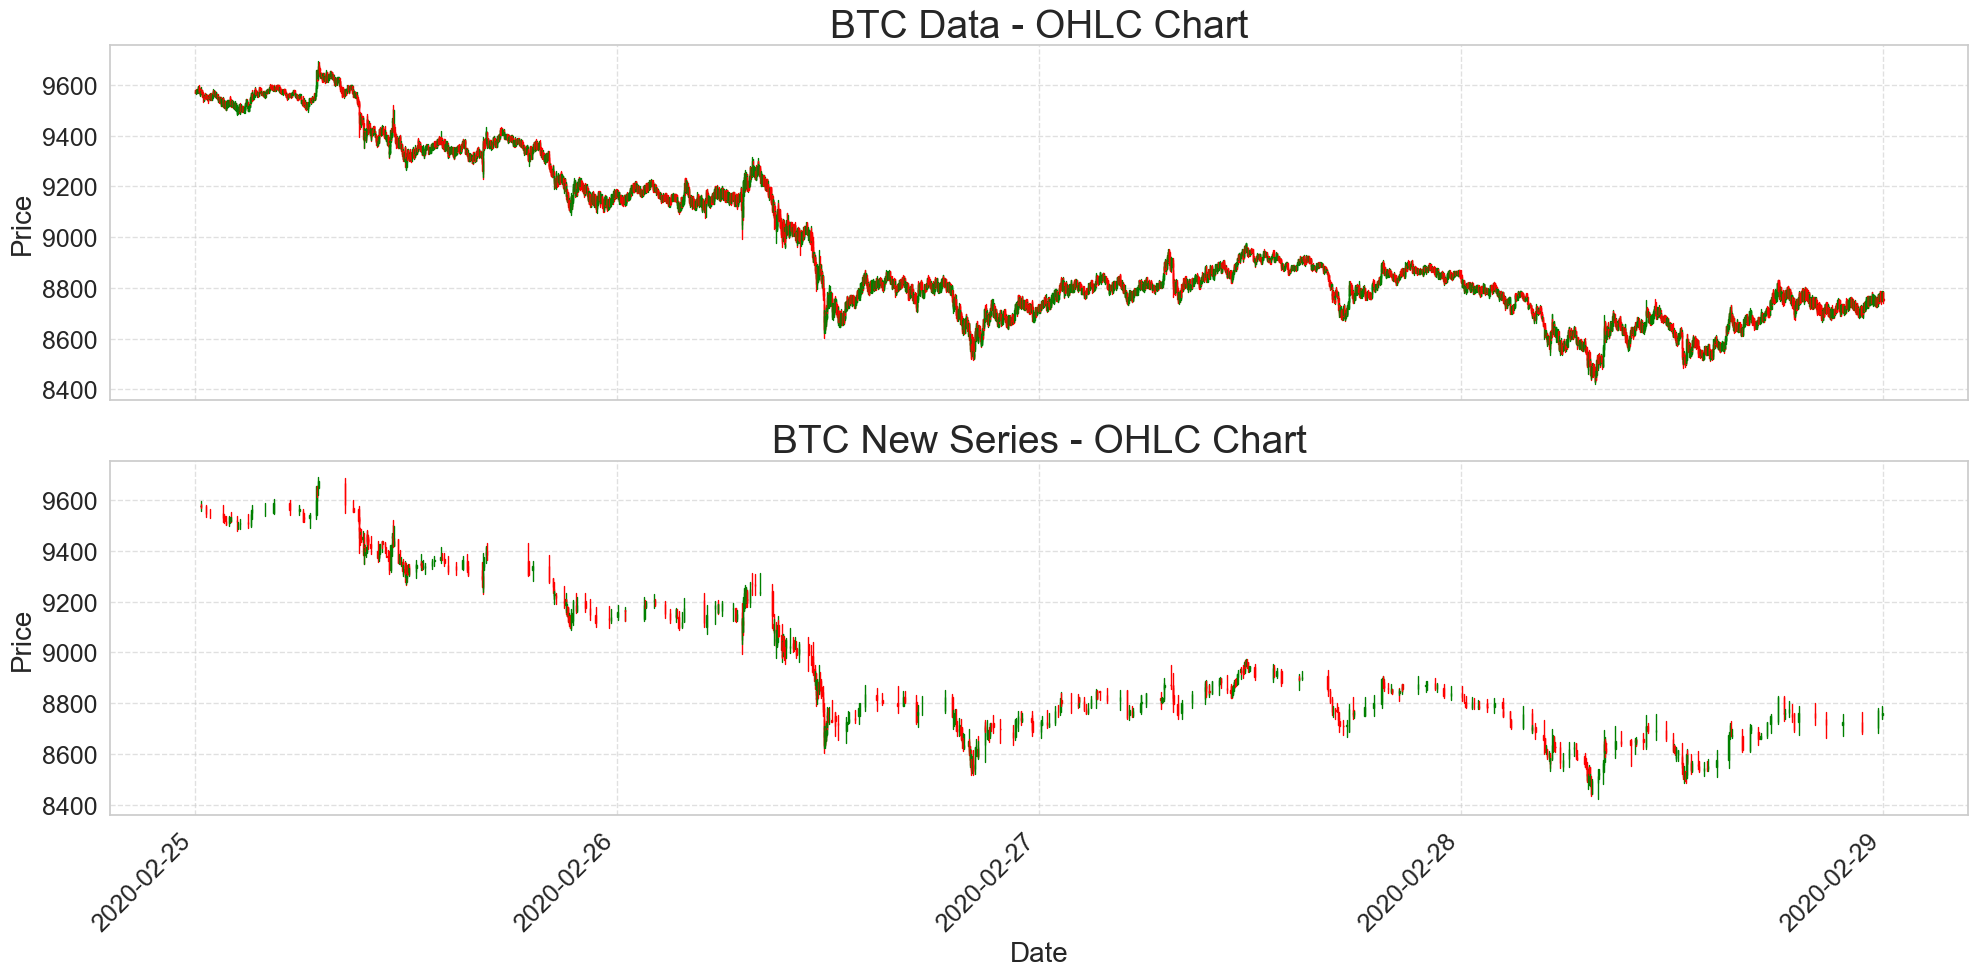

In [100]:
filename = 'btc_original_volume_imabalance_comp'

# Asegurarse de que la columna 'date' es de tipo datetime
btc_data['date'] = pd.to_datetime(btc_data['date'])
btc_new_series_dollar['date'] = pd.to_datetime(btc_new_series_dollar['date'])

# Filtrar los datos para los meses de febrero y marzo de 2020
covid_start = '2020-02-25'
covid_end = '2020-02-29'

btc_data_filtered = btc_data[(btc_data['date'] >= covid_start) & (btc_data['date'] <= covid_end)]
btc_new_series_filtered = btc_new_series_dollar[(btc_new_series_dollar['date'] >= covid_start) & (btc_new_series_dollar['date'] <= covid_end)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

plot_ohlc(ax1, btc_data_filtered, color_up='green', color_down='red')
plot_ohlc(ax2, btc_new_series_filtered, color_up='green', color_down='red')

for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax.yaxis.set_tick_params(labelsize=18)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_facecolor('white')

ax1.set_title('BTC Data - OHLC Chart', fontsize=28)
ax1.set_ylabel('Price', fontsize=20)
ax2.set_title('BTC New Series - OHLC Chart', fontsize=28)
ax2.set_xlabel('Date', fontsize=20)
ax2.set_ylabel('Price', fontsize=20)

plt.tight_layout()
plt.show()

In [101]:
# Realizar el test de Jarque-Bera
jb_stat, p_value = stats.jarque_bera(log_returns)

print(f"JB Statistic: {jb_stat}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.")
else:
    print("No se puede rechazar la hipótesis nula: Los datos siguen una distribución normal.")

JB Statistic: 780276155.6724092
p-value: 0.0
Rechazamos la hipótesis nula: Los datos no siguen una distribución normal.
